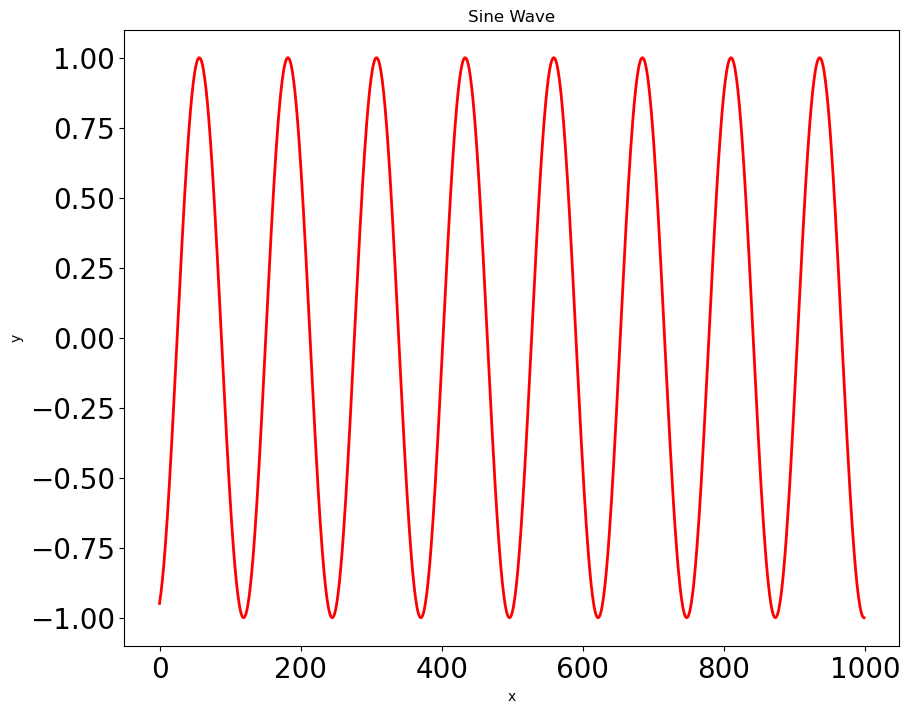

Step 0
Loss: 0.5213286876678467
Loss: 0.5107975006103516
Loss: 0.4874590337276459
Loss: 0.4767603874206543
Loss: 0.4408920407295227
Loss: 0.2778012752532959
Loss: 0.12058873474597931
Loss: 0.04946916922926903
Loss: 0.11364298313856125
Loss: 0.03576051443815231
Loss: 0.02550295554101467
Loss: 0.023364078253507614
Loss: 0.022992148995399475
Loss: 0.021106019616127014
Loss: 0.01812012866139412
Loss: 0.013277754187583923
Loss: 0.005451463628560305
Loss: 0.004365349188446999
Loss: 0.0034209564328193665
Loss: 0.0022606607526540756
Test loss: 0.005076597444713116
Step 1
Loss: 0.0051026116125285625
Loss: 0.0010457970201969147
Loss: 0.0009378565009683371
Loss: 0.0008726257947273552
Loss: 0.0008527290774509311
Loss: 0.0008478673407807946
Loss: 0.000842968700453639
Loss: 0.0008213260443881154
Loss: 0.0007858119788579643
Loss: 0.0007359818555414677
Loss: 0.000655710173305124
Loss: 0.0005121787544339895
Loss: 0.0004304670437704772
Loss: 0.0003723620611708611
Loss: 0.00031305354787036777
Loss: 0.000

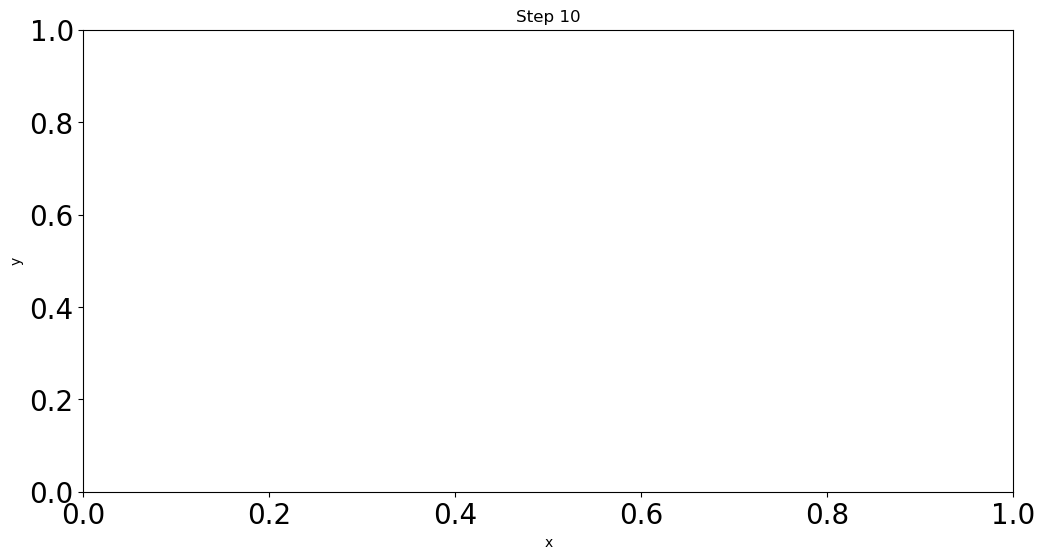

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Parameters for generating sine wave data
N = 100
L = 1000
T = 20

# Generate sine wave data
x = np.empty((N, L), np.float32)
x[:] = np.array(range(L)) + np.random.randint(-4*T, 4*T, N).reshape(N, 1)
y = np.sin(x / 1.0 / T).astype(np.float32)

# Plotting sine wave
plt.figure(figsize=(10, 8))
plt.title("Sine Wave")
plt.xlabel("x")
plt.ylabel("y")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(np.arange(x.shape[1]), y[0, :], 'r', linewidth=2.0)
plt.show()

class LSTMPredictor(nn.Module):
    def __init__(self, n_hidden=51):
        super(LSTMPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.lstm1 = nn.LSTMCell(1, self.n_hidden)
        self.lstm2 = nn.LSTMCell(self.n_hidden, self.n_hidden)
        self.linear = nn.Linear(self.n_hidden, 1)

    def forward(self, x, future=0):
        outputs = []
        batch_size = x.size(0)
        sequence_length = x.size(1)
        
        h_t = torch.zeros(batch_size, self.n_hidden, dtype=torch.float32)
        c_t = torch.zeros(batch_size, self.n_hidden, dtype=torch.float32)
        
        h_t2 = torch.zeros(batch_size, self.n_hidden, dtype=torch.float32)
        c_t2 = torch.zeros(batch_size, self.n_hidden, dtype=torch.float32)

        for input_t in x.split(1, dim=1):
            h_t, c_t = self.lstm1(input_t.squeeze(1), (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)

        for i in range(future):
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)

        outputs = torch.cat(outputs, dim=1)
        return outputs

if __name__ == "__main__":
    # Prepare data tensors
    train_input = torch.from_numpy(y[3:, :-1])
    train_target = torch.from_numpy(y[3:, 1:])
    test_input = torch.from_numpy(y[:3, :-1])
    test_target = torch.from_numpy(y[:3, 1:])

    # Reshape inputs to (batch_size, sequence_length, input_size)
    train_input = train_input.unsqueeze(-1)
    test_input = test_input.unsqueeze(-1)

    model = LSTMPredictor()
    criterion = nn.MSELoss()
    optimizer = optim.LBFGS(model.parameters(), lr=0.8)

    n_steps = 10
    for i in range(n_steps):
        print("Step", i)

        def closure():
            optimizer.zero_grad()
            out = model(train_input)
    
            # Adjust train_target to match out shape
            target_slice = train_target[:, :out.size(1)]  # Adjusting to match output length
    
            loss = criterion(out[:, :target_slice.size(1)].squeeze(), target_slice.squeeze())
            print("Loss:", loss.item())
            loss.backward()
            return loss

        optimizer.step(closure)

        with torch.no_grad():
            future = 1000
            pred = model(test_input, future=future)
            loss = criterion(pred[:, :-future].squeeze(), test_target.squeeze())
            print("Test loss:", loss.item())
            y_pred = pred.detach().numpy()
        def draw(y_i, color, future=0):
            n = y_i.shape[0]  # Shape[0] because y_i is expected to be a 1D array
            plt.plot(np.arange(n), y_i[:n], color, linewidth=2.0)
            if future > 0:
                plt.plot(np.arange(n, n + future), y_i[n:], color + ":", linewidth=2.0)

        draw(y_pred[0], 'r')
        draw(y_pred[1], 'b')
        draw(y_pred[2], 'g')

        plt.savefig(f"predict_{i}.pdf")
        plt.close()

        plt.figure(figsize=(12, 6))
        plt.title(f"Step {i+1}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)

        n = train_input.shape[1]
        
   